<a href="https://colab.research.google.com/github/ankishore/predict_taxi_fare/blob/main/taxi_fare_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ankishore/predict_taxi_fare/main/NYCTaxiFares.csv')
df.head()
#df['fare_amount'].describe()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


# Feature engineering
Fix/upgrade dataset to make it easier for ANN to learn

## Add distance column
If not for this column, ANN would have to figure out co-relation between source and distance latitude/longitude. Note, since dataset is from within same city, change in latitude/longitude would be very small making it even more complex for ANN to learn this.

In [3]:
# Formula details from https://en.wikipedia.org/wiki/Haversine_formula
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

# Add new column
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head() # print dataframe head records

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Extract useful features out of timestamp

In [4]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4) # Convert UTC to EDT (Eastern Daylight Time)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12, 'am', 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()
#df['EDTdate'].min()
#df['EDTdate'].max()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


## Separate categorical from continous columns

In [5]:
# All columns
#df.columns

cat_cols = ['Hour', 'AMorPM', 'Weekday']

# We'll not pass other continuous columns to ANN e.g. 'EDTdate', 'pickup_datetime' etc
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

# Labels
y_col = ['fare_amount']

## Convert category column entries to codes

In [6]:
# Convert to category dtype
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

#df.dtypes
#df['Hour'].head()
#df['Hour'].cat.categories
#df['Hour'].head().cat.codes

# Stack together all categorical columns
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

## Convert numpy arrays to tensors

In [7]:
# Convert categorical variables to tensor
cats = torch.tensor(cats, dtype=torch.int64)

# Convert continuous variables to tensor
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)

# Convert labels to tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

## Set embedding size for categorical data

In [8]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

# embedding size is min(50, half_category_size)
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

emb_szs

[(24, 12), (2, 1), (7, 4)]

# Design model

In [9]:
class TabularModel(nn.Module):
  # emb_szs: Embedding size (in, out) for each column in categorical dataset
  # n_cont: Number of continuous dataset columns
  # out_sz: Number of outputs
  # layers: Number of neurons per hidden layer. len(layers) is number of hidden layers
  # p: Dropout probability
  def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
    super().__init__()

    # Setup embeddings
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])

    # Setup dropout for embeddings
    self.emb_drop = nn.Dropout(p)

    # Setup normalization for input continuous dataset
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerlist = []

    # Count number of input features (embeddings + continuous columns)
    n_emb = sum((nf for ni,nf in emb_szs))
    n_in = n_emb + n_cont

    # Chain all operations on hidden layers in order we want Model to do forward propagation 
    for i in layers:
      layerlist.append(nn.Linear(n_in, i)) # Add a layer with input n_in and number of neurons i
      layerlist.append(nn.ReLU(inplace=True)) # Apply ReLU activation function. Modify inputs in place
      layerlist.append(nn.BatchNorm1d(i)) # Normalize data for next layer
      layerlist.append(nn.Dropout(p)) # Add dropout per layer
      n_in = i # Update number of inputs for next layer
    
    # Add final output layer
    layerlist.append(nn.Linear(layers[-1], out_sz))

    # Sequential container forward() method accepts any input and forwards it to first module it contains.
    # It then chains outputs to inputs sequentially for each subsequent module, finally returning output of last module.
    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_cat, x_cont):

    # Pass x_cat features through embeddings
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:, i]))
    
    # Concatenate above embeddings vertically
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x) # Add dropout to embeddings

    x_cont = self.bn_cont(x_cont) # Normalize continuous dataset

    # Concatenate normalized continuous and embedded categorical features
    x = torch.cat([x, x_cont], 1)

    # Pass inputs to sequential container
    x = self.layers(x)

    return x

## Instantiate model

In [10]:
# Create model with 1 output, 2 hidden layers [200, 100] and dropout probability of 0.4
model = TabularModel(emb_szs, conts.shape[1], 1, [200, 100], p=0.4)

model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Setup loss function and optimizer

In [11]:
# Mean squared error. However, for training we'll use sqrt(MSE)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

## Perform train/test splits

In [13]:
batch_size = 60000
test_size = int(batch_size * .2)

# Split categorical dataset
cat_train = cats[:batch_size - test_size]
cat_test = cats[batch_size - test_size:batch_size]

# Split continuous dataset
con_train = conts[:batch_size - test_size]
con_test = conts[batch_size - test_size: batch_size]

# Split Labels
y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size: batch_size]

## Train the model

In [14]:
import time

start_time = time.time()
epochs = 300
losses = [] # Cache loss from each epoch

for i in range(epochs):
  y_pred = model(cat_train, con_train)
  loss = torch.sqrt(criterion(y_pred, y_train)) # sqrt(RMS)
  losses.append(loss)

  if i%25 == 0:
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  
  optimizer.zero_grad() # Set gradient to 0
  loss.backward() # Calculate gradient
  optimizer.step() # Back propagate. Updates parameters

print(f'epoch: {i:3} loss: {loss.item():10.8f}') # print the final loss
print(f'Duration: {time.time() - start_time:.0f} seconds')

epoch:   0 loss: 12.50106335
epoch:  25 loss: 10.71521759
epoch:  50 loss: 10.10907936
epoch:  75 loss: 9.67308235
epoch: 100 loss: 9.12350941
epoch: 125 loss: 8.35226250
epoch: 150 loss: 7.33614349
epoch: 175 loss: 6.11874199
epoch: 200 loss: 4.97743177
epoch: 225 loss: 4.14183950
epoch: 250 loss: 3.82947636
epoch: 275 loss: 3.74550986
epoch: 299 loss: 3.66794276
Duration: 121 seconds


## Plot loss

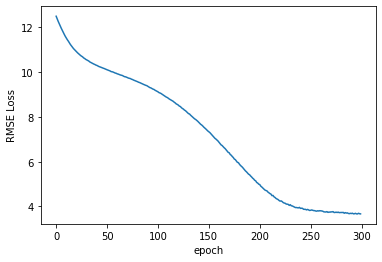

In [25]:
with torch.no_grad(): # Pyplot can't plot tensors which gradient enabled
  plt.plot(range(epochs), losses)
  plt.xlabel('epoch')
  plt.ylabel('RMSE Loss')

# Validate model

In [26]:
with torch.no_grad():
  y_val = model(cat_test, con_test)
  loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.56644082
